# Tools for Car Object Detection - Bounding Box Regression Model

<img width="1109" alt="Screen Shot 2023-10-03 at 12 13 27 PM" src="https://github.com/nickthetj/CarObjectDetection/assets/37059423/bf1b8802-b453-44ea-8dde-fe1a0ddcfe1d">
(Source: Zapp2Photo/Shutterstock.com)

## Overview
Object recognition is the linchpin for self-driving cars. It enables self-driving cars to identify and respond to objects like pedestrians and vehicles in real-time, ensuring safer autonomous driving. This notebook will walk through three object detection models that can identify and draw bounding-boxes around cars on the road: YOLOv8, R-CNN, and Bounding Box Regression (BB). The YOLOv8 model was implemented with the pre-packaged model from Ultralytics, and R-CNN and BB were built from the ground up. We will walk through differences between each model on a conceptual level, their implementation and respective evaluation scores. 

## Business Problem
These object detection models were developed as a tool for autonomous vehicles and traffic safety cameras to enable the cameras to perceive and understand its environment by identifying and locating objects of interest in real-time. Specifically in identifying and locating where cars are in a picture.

## The Data
The data was taken from a kaggle dataset consisting of 1176 street view images divided into test and training sets. Some of these images consisted of cars and others did not. The dataset also included bounding box informations associated with each image. There were no labels for this dataset as there was only one class of object, a car. 

To download this dataset visit the following link: https://www.kaggle.com/datasets/sshikamaru/car-object-detection

## Imports

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2
import os
from mean_average_precision import MetricBuilder

## Data Preparation

In [2]:
path = "data/training_images/"
annot = "data/annotations"

In [3]:
images = []
targets = []
filenames = []

### Creating Training, Testing and Validation sets

First we want to read the upper level annotation file with all the bounding box information associated with each image. Then split perform our first train-test split on this folder with a test size of 20%.

Finally we will break down our newly created train split into another split: our final training set and our validation split, also with a validation size of 20%.

And thus we are left with a test, validation, and training set which respectively are 20%, 16% and 64% of the original file.

In [4]:
# read in upper level annotation file and extract bounding box information
for e,i in enumerate(os.listdir(annot)):
    filename = i.split(".")[0]+".jpg"
    img = cv2.imread(os.path.join(path,filename))
    df = pd.read_csv(os.path.join(annot,i))
    (h,w) = img.shape[:2]
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        x1_norm = float(x1) / w
        y1 = int(row[1][0].split(" ")[1])
        y1_norm = float(y1) / h
        x2 = int(row[1][0].split(" ")[2])
        x2_norm = float(x2) / w
        y2 = int(row[1][0].split(" ")[3])
        y2_norm = float(y2) / h
        break
    img = load_img(os.path.join(path,filename), target_size=(224, 224))
    img = img_to_array(img)
    images.append(img)
    targets.append((x1_norm, y1_norm, x2_norm, y2_norm))
    filenames.append(filename)

In [6]:
# Create testing set
images = np.array(images, dtype='float32')/255.0
targets = np.array(targets, dtype='float32')
trainTestSplit = train_test_split(images, targets, filenames, test_size=0.2)
trainImages, testImages = trainTestSplit[:2]
trainTargets, testTargets = trainTestSplit[2:4]
trainFilenames, testFilenames = trainTestSplit[4:]

In [7]:
# Create training and validation sets
trainValSplit = train_test_split(trainImages, trainTargets, trainFilenames, test_size=0.2)
trainImages, valImages = trainValSplit[:2]
trainTargets, valTargets = trainValSplit[2:4]
trainFilenames, valFilenames = trainValSplit[4:]

In [8]:
# Save testing set information to a text file for final evaluation
print("[INFO] saving testing filenames...")
f = open('saved_imagestxt_reg/test_images.txt', "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


## Modeling

Here we are loading a pretrained model, namely VGG16, a very popular convolutional neural network used for feature extracting images. This will be used as our backbone model.

Then we need to append the head of the neural network at the end of our backbone model, which will make predictions on our bounding boxes. If have more object classes we can add another head which will make predictions on our class labels. 

In [9]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In the following cell we compile the model with a learning rate of 0.025.

Then we perform our fit with a batch size of 32 and 25 epochs. There is also an early stopping condition that monitors the loss.

In [11]:
model.compile(loss="mse", metrics=["accuracy"], optimizer=Adam(lr=0.025))
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
BoundingBox = model.fit(trainImages, trainTargets, validation_data=(valImages, valTargets), batch_size=32, epochs=25, verbose=1, callbacks=[checkpoint,early])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Epoch 1/25
8/8 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.5859
Epoch 1: val_loss improved from inf to 0.07489, saving model to ieeercnn_vgg16_1.h5


/Users/nicholastjandra/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 48s 6s/step - loss: 0.1106 - accuracy: 0.5859 - val_loss: 0.0749 - val_accuracy: 0.6842
Epoch 2/25
8/8 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.6828
Epoch 2: val_loss improved from 0.07489 to 0.06548, saving model to ieeercnn_vgg16_1.h5
8/8 [==============================] - 44s 6s/step - loss: 0.0783 - accuracy: 0.6828 - val_loss: 0.0655 - val_accuracy: 0.6842
Epoch 3/25
8/8 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.6828
Epoch 3: val_loss improved from 0.06548 to 0.05977, saving model to ieeercnn_vgg16_1.h5
8/8 [==============================] - 41s 5s/step - loss: 0.0631 - accuracy: 0.6828 - val_loss: 0.0598 - val_accuracy: 0.6842
Epoch 4/25
8/8 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.6828
Epoch 4: val_loss improved from 0.05977 to 0.05796, saving model to ieeercnn_vgg16_1.h5
8/8 [==============================] - 50s 6s/step - loss: 0.0546 - accuracy: 0

Then we need to save the model instance to be used for predictions

In [20]:
print("[INFO] saving object detector model...")
model.save('saved_models_reg/detector.f5', save_format="h5")

[INFO] saving object detector model...


The following cell plots the loss across teh 25 epochs of training.

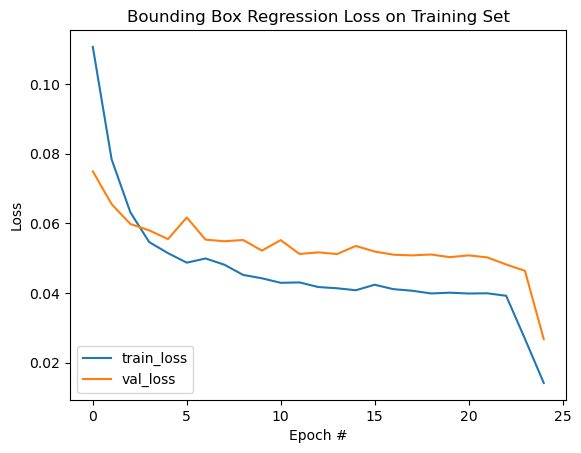

In [91]:
N = 25
plt.figure()
plt.plot(np.arange(0, N), BoundingBox.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), BoundingBox.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('saved_figures_reg/plot.png')

## Evaluation

In [87]:
# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model('saved_models_reg/detector.f5')
# grab a random image from our data folder
image = load_img(f'{path}vid_4_920.jpg', target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

[INFO] loading object detector...


The following cell visualizes what our predictions look like.

1/1 [==============================] - 0s 281ms/step


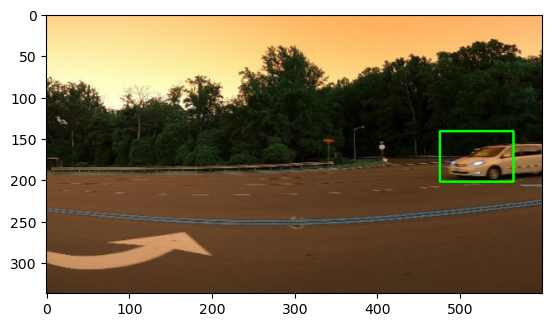

In [88]:
# make bounding box predictions on the input image
preds = model.predict(image)[0]
(startX, startY, endX, endY) = preds
# load the input image (in OpenCV format), resize it such that it
# fits on our screen, and grab its dimensions
image = cv2.imread(os.path.join(path,'vid_4_920.jpg'))
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
# draw the predicted bounding box on the image
cv2.rectangle(image, (startX, startY), (endX, endY),
    (0, 255, 0), 2)
# show the output image
plt.figure()

plt.imshow(image)

# cv2.imshow("Output", image)
# cv2.waitKey(0)

### Validation Set Evaluation mAP score

In [81]:
# creating a function that computes mAP metric for evaluating object detection models
def evaluate_val(model, model_name):
    # getting the predictions for the bounding boxes
    preds = []

    for i in range(len(valFilenames)):
        image = load_img(os.path.join(path,valFilenames[i]), target_size=(224, 224))
        image = img_to_array(image) / 255.0
        image = np.expand_dims(image, axis=0)
    
        (bboxPred) = model.predict(image)
    
        (startX, startY, endX, endY) = bboxPred[0]
        startX = int(startX * 224)
        startY = int(startY * 224)
        endX = int(endX * 224)
        endY = int(endY * 224)
        preds.append([startX, startY, endX, endY])

    # preds format = [xmin, ymin, xmax, ymax]
    preds = np.array(preds)
    # print(preds)

    
    # getting the ground truths for bounding boxes and class labels (and setting "difficult" and "crowd" to 0)
    gts = []

    for i in range(len(valFilenames)):
        (gt_startX, gt_startY, gt_endX, gt_endY) = valTargets[i]
        gt_startX = int(gt_startX * 224)
        gt_startY = int(gt_startY * 224)
        gt_endX = int(gt_endX * 224)
        gt_endY = int(gt_endY * 224)
        gts.append([gt_startX, gt_startY, gt_endX, gt_endY, 1, 0, 0])


    # gts format = [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
    gts = np.array(gts)
    print(gts.shape)
    print(preds.shape)
    # instantiating map function and adding preds and gts to it               
    map_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=1)
    for i in range(len(valFilenames)):
        map_fn.add(preds, gts)
    
    # computing mAP metric
    coco_map = map_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']


    print(f"COCO mAP for {model_name} test data: {coco_map}")
    
    # returning a dictionary of the mAP score
    result_val = {'model': model_name, 'coco_map': coco_map}
    return result_val

In [82]:
evaluate_val(model, 'Bounding Box model')

mAP for  validation data: 0.8237

### Test Set Evaluation mAP score

In [ ]:
# creating a function that computes mAP metric for evaluating object detection models
def evaluate_test(model, model_name):
    # getting the predictions for the bounding boxes
    preds = []

    for i in range(len(testFilenames)):
        # print(testFilenames[i])
        image = load_img(os.path.join(path,testFilenames[i]), target_size=(224, 224))
        image = img_to_array(image) / 255.0
        image = np.expand_dims(image, axis=0)
    
        (bboxPred) = model.predict(image)
    
        (startX, startY, endX, endY) = bboxPred[0]
        startX = int(startX * 224)
        startY = int(startY * 224)
        endX = int(endX * 224)
        endY = int(endY * 224)
        preds.append([startX, startY, endX, endY, 1, 0, 0])

    # preds format = [xmin, ymin, xmax, ymax]
    preds = np.array(preds)
    # print(preds)

    
    # getting the ground truths for bounding boxes and class labels (and setting "difficult" and "crowd" to 0)
    gts = []

    for i in range(len(testFilenames)):
        (gt_startX, gt_startY, gt_endX, gt_endY) = testTargets[i]
        gt_startX = int(gt_startX * 224)
        gt_startY = int(gt_startY * 224)
        gt_endX = int(gt_endX * 224)
        gt_endY = int(gt_endY * 224)
        gts.append([gt_startX, gt_startY, gt_endX, gt_endY, 1, 0, 0])

    # gts format = [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
    gts = np.array(gts)
    print(gts.shape)
    print(preds.shape)
    # instantiating map function and adding preds and gts to it               
    map_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=1)
    for i in range(len(testFilenames)):
        map_fn.add(preds, gts)
    
    # computing mAP metric
    coco_map = map_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']

    print(f"COCO mAP for {model_name} test data: {coco_map}")
    
    # returning a dictionary of the mAP score
    result_test = {'model': model_name, 'coco_map': coco_map}
    # return result_test

In [85]:
evaluate_test(model, 'Bounding Box model')

mAP for  test data: 0.72324